# MAML Detector Evaluation

## Empirical Analysis of Model-Agnostic Meta-Learning for Few-Shot MCP Security

---

### Abstract

This notebook presents a comprehensive evaluation of the MAML (Model-Agnostic Meta-Learning) Detector, an optional component of the MCP Security Gateway ensemble designed for few-shot adaptation to new tools. Based on Finn et al. (2017), this detector learns a meta-initialization that enables rapid task-specific adaptation with minimal training examples.

### Detector Characteristics

| Property | Value |
|----------|-------|
| **Type** | Meta-Learning (MAML) |
| **Encoder** | DistilBERT (768-dim embeddings) |
| **Classifier** | 3-layer MLP (768 → 256 → 128 → 2) |
| **Adaptation** | 5 gradient steps per task |
| **Few-Shot** | 5 examples per class |

### MAML Algorithm Overview

The MAML algorithm learns an initialization $\theta^*$ such that:

$$\theta^* = \arg\min_\theta \sum_{\mathcal{T}_i \sim p(\mathcal{T})} \mathcal{L}_{\mathcal{T}_i}(f_{\theta'_i})$$

Where $\theta'_i = \theta - \alpha \nabla_\theta \mathcal{L}_{\mathcal{T}_i}(f_\theta)$ is the task-adapted parameters.

### Key Advantages

1. **Few-Shot Learning**: Adapt to new tools with 5-10 examples per class
2. **Transfer Learning**: Meta-learned initialization transfers across tools
3. **Fast Adaptation**: Only 5 gradient steps for task-specific fine-tuning
4. **Generalization**: Learns to learn, enabling adaptation to unseen tool types

### References

- Finn, C., Abbeel, P., & Levine, S. (2017). *Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks*. ICML.
- Nichol, A., Achiam, J., & Schulman, J. (2018). *On First-Order Meta-Learning Algorithms*. arXiv.

---

## 1. Environment Configuration

In [1]:
import os
import sys
import json
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.manifold import TSNE
from typing import Dict, List, Tuple, Any, Optional
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configure project paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.insert(0, PROJECT_ROOT)

# Import detector
from mcp_bridge.src.core.detectors.maml import MAMLDetector, MAMLConfig
from mcp_bridge.src.core.detectors.base import SecurityClass

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"MAML Detector Evaluation")
print(f"="*60)
print(f"Project Root: {PROJECT_ROOT}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

MAML Detector Evaluation
Project Root: w:\__Projects__\MCP-Security-Gateway
PyTorch Version: 2.9.1+cu130
CUDA Available: True


## 2. Visualization Configuration

In [2]:
# Color palette
COLORS = {
    'primary': '#CC79A7',      # Reddish Purple - MAML detector
    'benign': '#009E73',       # Green - Safe
    'attack': '#D55E00',       # Vermillion - Threat
    'neutral': '#7F7F7F',      # Gray
    'secondary': '#0072B2',    # Blue
    'meta': '#56B4E9',         # Sky Blue - Meta-learning
    'adapted': '#E69F00',      # Orange - Adapted
}

# Publication-quality matplotlib configuration
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Output directories
FIGURES_DIR = os.path.join(PROJECT_ROOT, 'research', 'figures', 'maml')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'research', 'evaluation_results')
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Figures: {FIGURES_DIR}")
print(f"Results: {RESULTS_DIR}")

Figures: w:\__Projects__\MCP-Security-Gateway\research\figures\maml
Results: w:\__Projects__\MCP-Security-Gateway\research\evaluation_results


## 3. Data Loading and Model Initialization

In [3]:
# Load datasets
TRAIN_DATA_PATH = os.path.join(PROJECT_ROOT, "research", "data", "training_dataset.json")
TEST_DATA_PATH = os.path.join(PROJECT_ROOT, "research", "data", "test_dataset.json")
MODELS_DIR = os.path.join(PROJECT_ROOT, "research", "trained_models")
MAML_MODEL_PATH = os.path.join(MODELS_DIR, "maml_model.pt")

def load_dataset(path: str) -> Dict:
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    data.pop('_metadata', None)
    return data

def flatten_samples(dataset: Dict) -> List[Dict]:
    samples = []
    for tool_name, tool_data in dataset.items():
        for category in ['benign', 'attack']:
            for payload in tool_data.get(category, []):
                if isinstance(payload, dict):
                    payload_str = json.dumps(payload)
                else:
                    payload_str = str(payload)
                samples.append({
                    'tool_name': tool_name,
                    'payload': payload_str,
                    'label': category
                })
    return samples

train_dataset = load_dataset(TRAIN_DATA_PATH)
test_dataset = load_dataset(TEST_DATA_PATH)

train_samples = flatten_samples(train_dataset)
test_samples = flatten_samples(test_dataset)

print(f"Training samples: {len(train_samples)}")
print(f"Test samples: {len(test_samples)}")

Training samples: 3088
Test samples: 304


In [4]:
# Initialize and load MAML detector
maml_config = MAMLConfig(
    meta_lr=0.001,
    inner_lr=0.01,
    adaptation_steps=5,
    first_order=True,
    shots=5,
    hidden_dim=256,
    confidence_threshold=0.6,
    num_meta_epochs=100
)

maml_detector = MAMLDetector(model_name="distilbert-base-uncased", config=maml_config)
maml_loaded = False

if os.path.exists(MAML_MODEL_PATH):
    state = torch.load(MAML_MODEL_PATH, map_location='cpu', weights_only=False)
    maml_detector.load_state(state)
    maml_loaded = True
    print(f"MAML model loaded from: {MAML_MODEL_PATH}")
    print(f"  Adapted tools: {len(maml_detector.adapted_models)}")
    print(f"  Tools: {list(maml_detector.adapted_models.keys())}")
    print(f"  Config: inner_lr={maml_detector.config.inner_lr}, steps={maml_detector.config.adaptation_steps}")
else:
    print("MAML model not found.")
    print("Note: MAML requires meta-training which is computationally expensive.")
    print("To train MAML, run: python research/tools/train_models.py --maml")

MAML model loaded from: w:\__Projects__\MCP-Security-Gateway\research\trained_models\maml_model.pt
  Adapted tools: 32
  Tools: ['check_file_exists', 'check_url', 'convert_time', 'create_entity', 'create_relation', 'delete_entity', 'describe_table', 'deserialize_data', 'execute_command', 'fetch_html', 'fetch_url', 'get_current_time', 'get_entity', 'get_file_info', 'get_relations', 'graphql_query', 'ldap_query', 'list_directory', 'list_entities', 'list_tables', 'parse_xml', 'read_file', 'read_query', 'redis_command', 'render_template', 'run_script', 's3_operation', 'search_entities', 'send_webhook', 'verify_jwt', 'write_file', 'write_query']
  Config: inner_lr=0.01, steps=5


## 4. MAML Configuration Analysis

### 4.1 Hyperparameter Overview

In [5]:
if maml_loaded:
    config = maml_detector.config
    
    print("MAML Hyperparameters")
    print("="*60)
    print(f"\nMeta-Learning:")
    print(f"  Meta learning rate (outer loop): {config.meta_lr}")
    print(f"  Inner learning rate (adaptation): {config.inner_lr}")
    print(f"  Adaptation steps: {config.adaptation_steps}")
    print(f"  First-order approximation: {config.first_order}")
    
    print(f"\nFew-Shot Task:")
    print(f"  Ways (classes): {config.ways}")
    print(f"  Shots (examples per class): {config.shots}")
    print(f"  Queries (evaluation per class): {config.queries}")
    
    print(f"\nArchitecture:")
    print(f"  Embedding dimension: {config.embedding_dim}")
    print(f"  Hidden dimension: {config.hidden_dim}")
    print(f"  Output classes: {config.ways}")
    
    print(f"\nClassification:")
    print(f"  Confidence threshold: {config.confidence_threshold}")
    print(f"  Temperature (softmax): {config.temperature}")

MAML Hyperparameters

Meta-Learning:
  Meta learning rate (outer loop): 0.001
  Inner learning rate (adaptation): 0.01
  Adaptation steps: 5
  First-order approximation: True

Few-Shot Task:
  Ways (classes): 2
  Shots (examples per class): 5
  Queries (evaluation per class): 5

Architecture:
  Embedding dimension: 768
  Hidden dimension: 256
  Output classes: 2

Classification:
  Confidence threshold: 0.6
  Temperature (softmax): 1.0


### 4.2 Training History Analysis

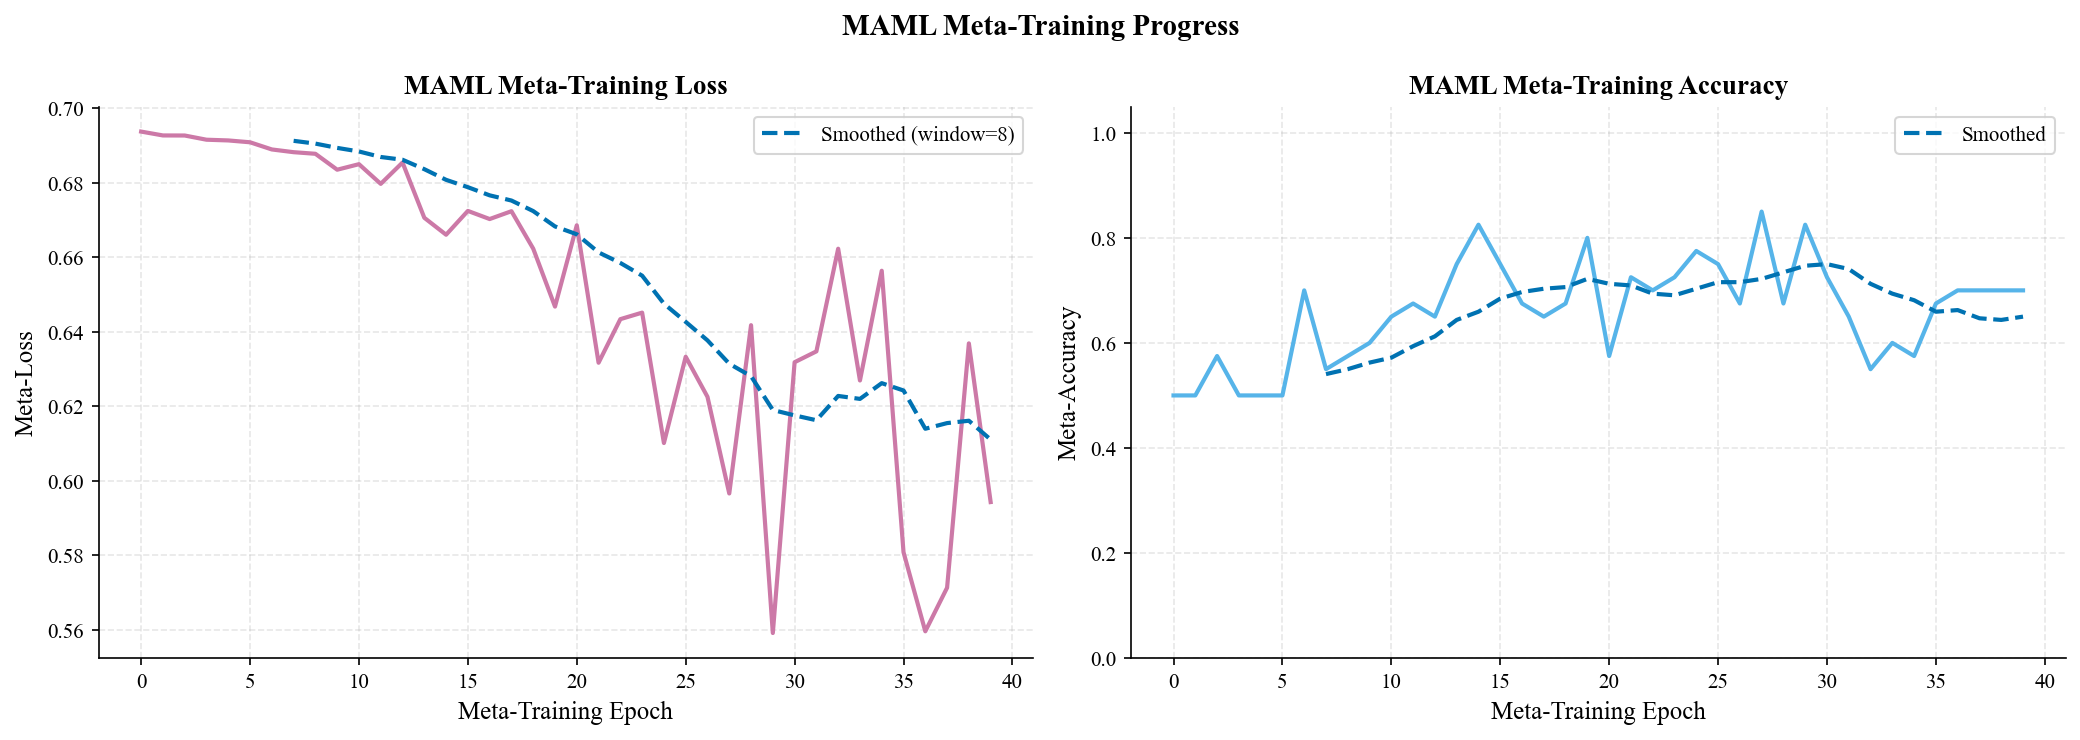


Training Summary:
  Total epochs: 40
  Initial loss: 0.6937
  Final loss: 0.5943
  Final accuracy: 0.7000


In [6]:
if maml_loaded and maml_detector.training_history.get('meta_loss'):
    meta_loss = maml_detector.training_history['meta_loss']
    meta_acc = maml_detector.training_history.get('meta_accuracy', [])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Meta-loss curve
    ax1 = axes[0]
    ax1.plot(meta_loss, color=COLORS['primary'], lw=2)
    ax1.set_xlabel('Meta-Training Epoch')
    ax1.set_ylabel('Meta-Loss')
    ax1.set_title('MAML Meta-Training Loss')
    
    # Add smoothed curve
    if len(meta_loss) > 10:
        window = min(10, len(meta_loss) // 5)
        smoothed = pd.Series(meta_loss).rolling(window=window).mean()
        ax1.plot(smoothed, color=COLORS['secondary'], lw=2, linestyle='--', label=f'Smoothed (window={window})')
        ax1.legend()
    
    # Meta-accuracy curve
    ax2 = axes[1]
    if meta_acc:
        ax2.plot(meta_acc, color=COLORS['meta'], lw=2)
        ax2.set_xlabel('Meta-Training Epoch')
        ax2.set_ylabel('Meta-Accuracy')
        ax2.set_title('MAML Meta-Training Accuracy')
        ax2.set_ylim(0, 1.05)
        
        if len(meta_acc) > 10:
            smoothed_acc = pd.Series(meta_acc).rolling(window=window).mean()
            ax2.plot(smoothed_acc, color=COLORS['secondary'], lw=2, linestyle='--', label=f'Smoothed')
            ax2.legend()
    
    plt.suptitle('MAML Meta-Training Progress', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'training_history.png'), dpi=600)
    plt.show()
    
    print(f"\nTraining Summary:")
    print(f"  Total epochs: {len(meta_loss)}")
    print(f"  Initial loss: {meta_loss[0]:.4f}")
    print(f"  Final loss: {meta_loss[-1]:.4f}")
    if meta_acc:
        print(f"  Final accuracy: {meta_acc[-1]:.4f}")
else:
    print("No training history available.")

### 4.3 Adapted Models Analysis

In [7]:
if maml_loaded:
    adapted_tools = list(maml_detector.adapted_models.keys())
    
    print(f"Adapted Models: {len(adapted_tools)} tools")
    print(f"Tools: {adapted_tools}")
    
    # Analyze classifier weights
    if adapted_tools:
        weight_norms = []
        for tool_name, model in maml_detector.adapted_models.items():
            total_params = sum(p.numel() for p in model.parameters())
            weight_norm = sum(p.norm().item() for p in model.parameters())
            weight_norms.append({
                'tool': tool_name,
                'params': total_params,
                'weight_norm': weight_norm
            })
        
        norm_df = pd.DataFrame(weight_norms)
        print(f"\nAdapted Model Statistics:")
        print(norm_df.to_string(index=False))

Adapted Models: 32 tools
Tools: ['check_file_exists', 'check_url', 'convert_time', 'create_entity', 'create_relation', 'delete_entity', 'describe_table', 'deserialize_data', 'execute_command', 'fetch_html', 'fetch_url', 'get_current_time', 'get_entity', 'get_file_info', 'get_relations', 'graphql_query', 'ldap_query', 'list_directory', 'list_entities', 'list_tables', 'parse_xml', 'read_file', 'read_query', 'redis_command', 'render_template', 'run_script', 's3_operation', 'search_entities', 'send_webhook', 'verify_jwt', 'write_file', 'write_query']

Adapted Model Statistics:
             tool  params  weight_norm
check_file_exists  230018    18.896297
        check_url  230018    18.896921
     convert_time  230018    18.905212
    create_entity  230018    18.909049
  create_relation  230018    18.898905
    delete_entity  230018    18.906540
   describe_table  230018    18.906343
 deserialize_data  230018    18.890631
  execute_command  230018    18.894363
       fetch_html  230018    1

## 5. Model Evaluation

### 5.1 Predictions on Test Set

In [8]:
def evaluate_maml_detector(samples: List[Dict]) -> pd.DataFrame:
    """Evaluate MAML detector on samples."""
    results = []
    
    for sample in samples:
        result = maml_detector.predict(sample['payload'], sample['tool_name'])
        
        if result is None:
            pred_label = 'abstain'
            confidence = 0.0
            benign_prob = 0.0
            attack_prob = 0.0
            adapted = False
        else:
            pred_label = result.classification
            confidence = result.confidence
            benign_prob = result.metadata.get('benign_prob', 0.0)
            attack_prob = result.metadata.get('attack_prob', 0.0)
            adapted = result.metadata.get('adapted', False)
        
        results.append({
            'tool_name': sample['tool_name'],
            'payload': sample['payload'][:80],
            'true_label': sample['label'],
            'pred_label': pred_label,
            'confidence': confidence,
            'benign_prob': benign_prob,
            'attack_prob': attack_prob,
            'adapted': adapted
        })
    
    return pd.DataFrame(results)

if maml_loaded:
    print("Evaluating MAML Detector on test set...")
    eval_df = evaluate_maml_detector(test_samples)
    print(f"Evaluation complete: {len(eval_df)} samples")
    print(f"\nPrediction distribution:")
    print(eval_df['pred_label'].value_counts())
    print(f"\nAdapted vs Non-adapted:")
    print(eval_df['adapted'].value_counts())
else:
    print("MAML detector not loaded. Skipping evaluation.")
    eval_df = pd.DataFrame()

Evaluating MAML Detector on test set...
Evaluation complete: 304 samples

Prediction distribution:
pred_label
attack    296
benign      8
Name: count, dtype: int64

Adapted vs Non-adapted:
adapted
True    304
Name: count, dtype: int64


### 5.2 Confusion Matrix

Coverage: 100.0% (304/304 samples)


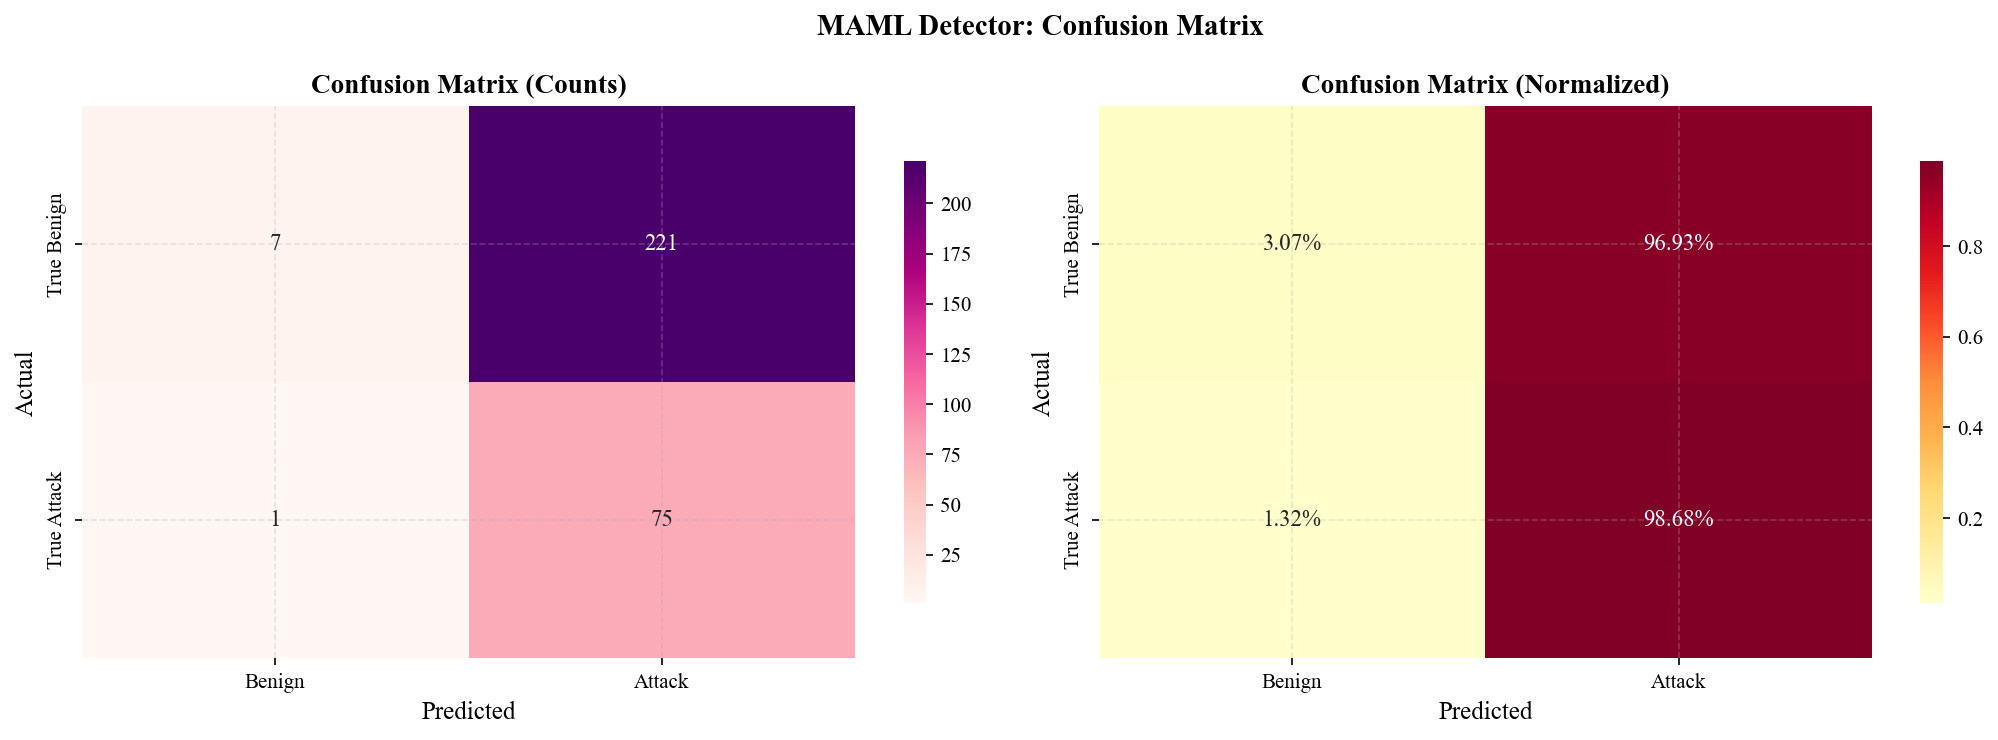

In [9]:
if maml_loaded and len(eval_df) > 0:
    # Filter out abstentions
    valid_df = eval_df[eval_df['pred_label'] != 'abstain'].copy()
    coverage = len(valid_df) / len(eval_df)
    
    print(f"Coverage: {coverage:.1%} ({len(valid_df)}/{len(eval_df)} samples)")
    
    if len(valid_df) > 0:
        labels = ['benign', 'attack']
        cm = confusion_matrix(valid_df['true_label'], valid_df['pred_label'], labels=labels)
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Absolute counts
        ax1 = axes[0]
        sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',
                    xticklabels=['Benign', 'Attack'],
                    yticklabels=['True Benign', 'True Attack'],
                    ax=ax1, cbar_kws={'shrink': 0.8})
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        ax1.set_title('Confusion Matrix (Counts)')
        
        # Normalized
        ax2 = axes[1]
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm_norm = np.nan_to_num(cm_norm)
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
                    xticklabels=['Benign', 'Attack'],
                    yticklabels=['True Benign', 'True Attack'],
                    ax=ax2, cbar_kws={'shrink': 0.8})
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('Actual')
        ax2.set_title('Confusion Matrix (Normalized)')
        
        plt.suptitle('MAML Detector: Confusion Matrix', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'), dpi=600)
        plt.show()

### 5.3 Classification Metrics

In [10]:
if maml_loaded and len(eval_df) > 0 and len(valid_df) > 0:
    y_true = (valid_df['true_label'] == 'attack').astype(int)
    y_pred = (valid_df['pred_label'] == 'attack').astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision_val = precision_score(y_true, y_pred, zero_division=0)
    recall_val = recall_score(y_true, y_pred, zero_division=0)
    f1_val = f1_score(y_true, y_pred, zero_division=0)
    
    print("Classification Metrics (Binary: Attack Detection)")
    print("="*60)
    print(f"Coverage: {coverage:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Attack']))

Classification Metrics (Binary: Attack Detection)
Coverage: 1.0000
Accuracy: 0.2697
Precision: 0.2534
Recall: 0.9868
F1-Score: 0.4032

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.03      0.06       228
      Attack       0.25      0.99      0.40        76

    accuracy                           0.27       304
   macro avg       0.56      0.51      0.23       304
weighted avg       0.72      0.27      0.15       304



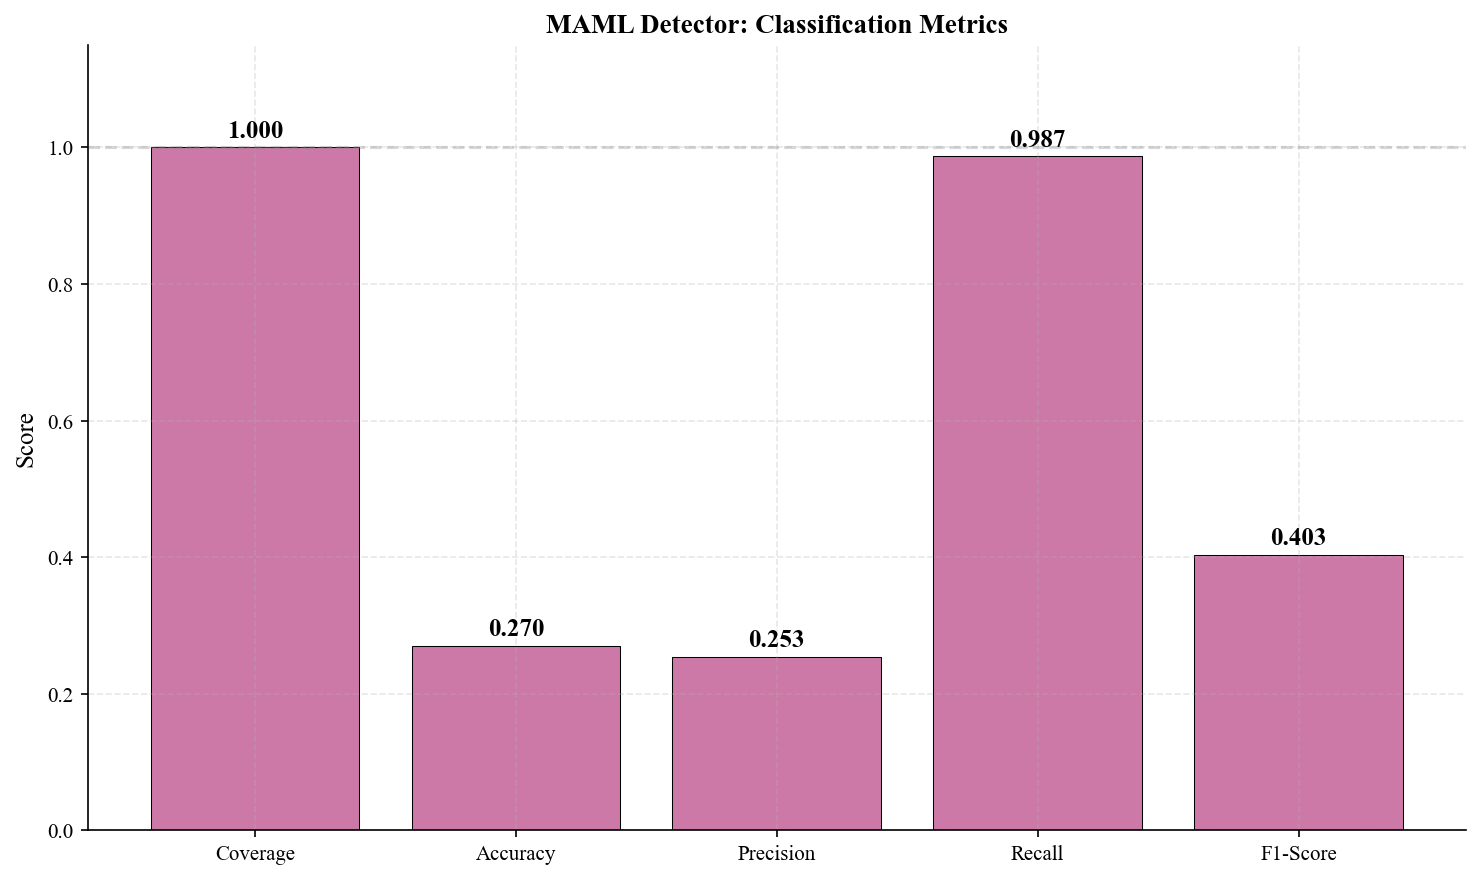

In [11]:
# Visualize metrics
if maml_loaded and len(eval_df) > 0 and len(valid_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    metrics = ['Coverage', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [coverage, accuracy, precision_val, recall_val, f1_val]
    
    bars = ax.bar(metrics, values, color=COLORS['primary'], edgecolor='black', linewidth=0.5)
    
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 5), textcoords='offset points', ha='center',
                    fontsize=12, fontweight='bold')
    
    ax.set_ylim(0, 1.15)
    ax.set_ylabel('Score')
    ax.set_title('MAML Detector: Classification Metrics')
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'classification_metrics.png'), dpi=600)
    plt.show()

### 5.4 ROC Curve and AUC

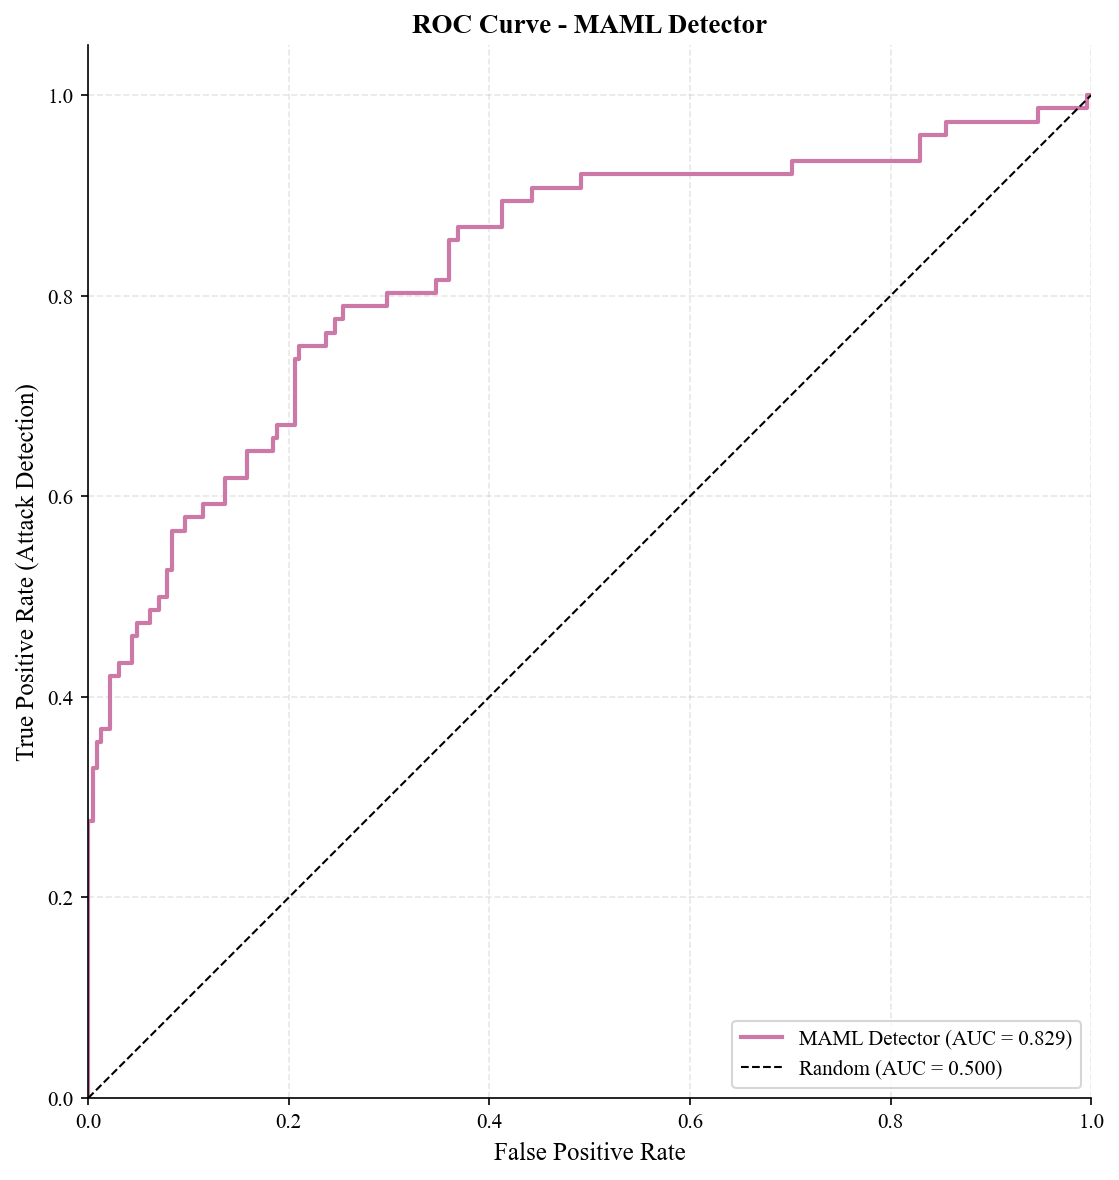

ROC-AUC Score: 0.8289


In [12]:
if maml_loaded and len(eval_df) > 0 and len(valid_df) > 0:
    # Use attack probability as score
    y_score = valid_df['attack_prob']
    
    fpr_roc, tpr_roc, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr_roc, tpr_roc)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(fpr_roc, tpr_roc, color=COLORS['primary'], lw=2,
            label=f'MAML Detector (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.500)')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Attack Detection)')
    ax.set_title('ROC Curve - MAML Detector')
    ax.legend(loc='lower right')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'), dpi=600)
    plt.show()
    
    print(f"ROC-AUC Score: {roc_auc:.4f}")

### 5.5 Precision-Recall Curve

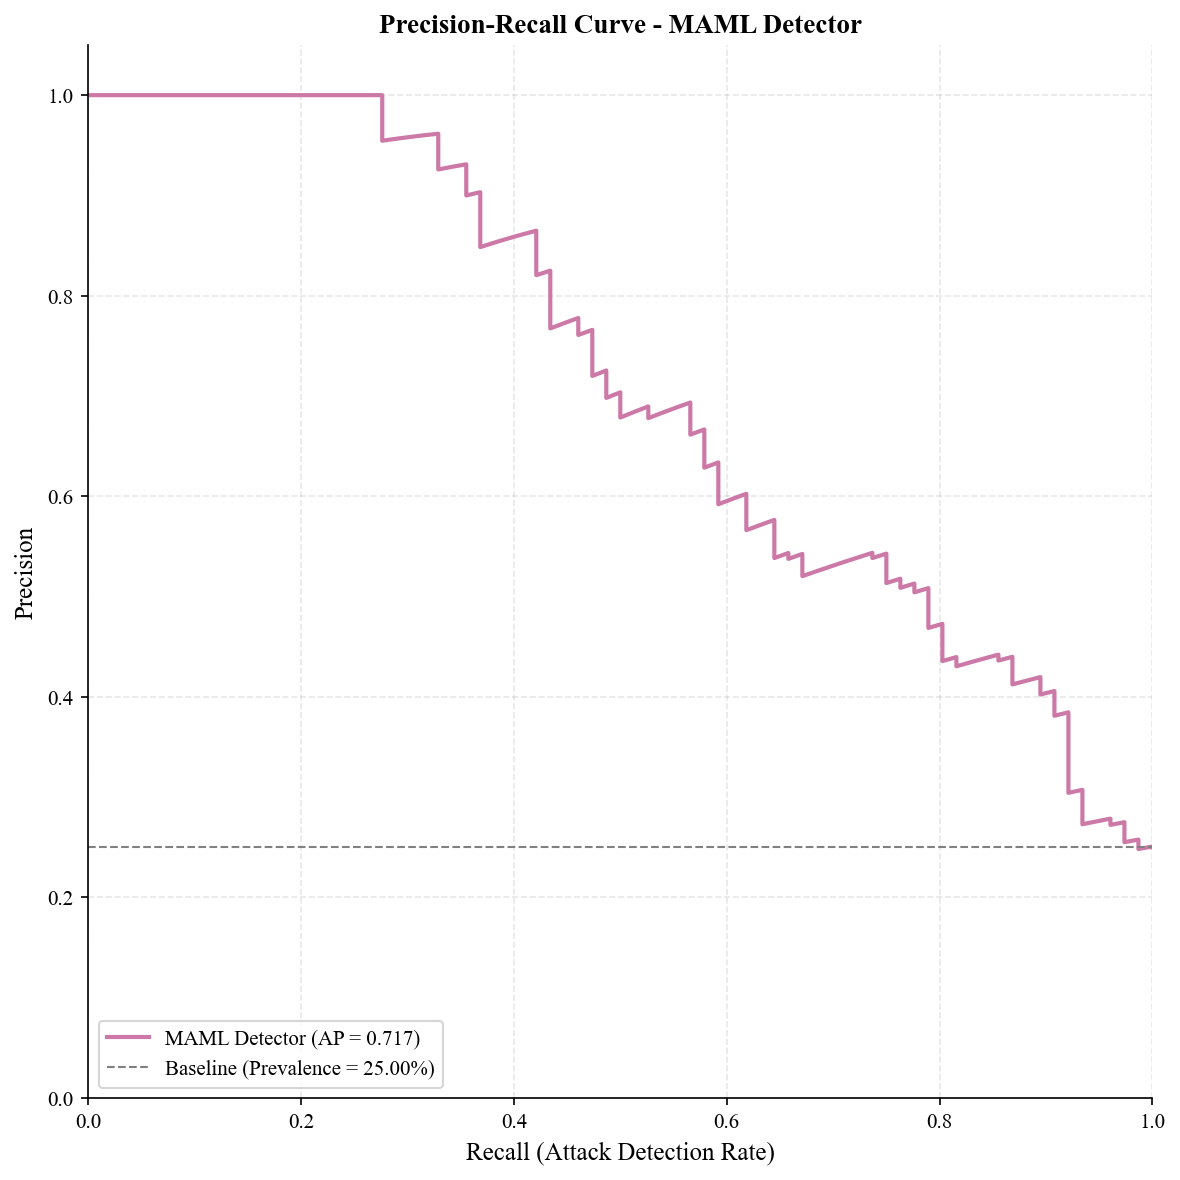

Average Precision (AP): 0.7168


In [13]:
if maml_loaded and len(eval_df) > 0 and len(valid_df) > 0:
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(recall_curve, precision_curve, color=COLORS['primary'], lw=2,
            label=f'MAML Detector (AP = {ap_score:.3f})')
    
    baseline = y_true.mean()
    ax.axhline(y=baseline, color='gray', linestyle='--', lw=1,
               label=f'Baseline (Prevalence = {baseline:.2%})')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('Recall (Attack Detection Rate)')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve - MAML Detector')
    ax.legend(loc='lower left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'precision_recall_curve.png'), dpi=600)
    plt.show()
    
    print(f"Average Precision (AP): {ap_score:.4f}")

## 6. Adaptation Analysis

### 6.1 Adapted vs Non-Adapted Performance

In [14]:
if maml_loaded and len(eval_df) > 0:
    # Compare adapted vs non-adapted performance
    adapted_df = eval_df[eval_df['adapted'] & (eval_df['pred_label'] != 'abstain')]
    non_adapted_df = eval_df[~eval_df['adapted'] & (eval_df['pred_label'] != 'abstain')]
    
    print("Adaptation Comparison")
    print("="*60)
    
    if len(adapted_df) > 0:
        y_true_adapted = (adapted_df['true_label'] == 'attack').astype(int)
        y_pred_adapted = (adapted_df['pred_label'] == 'attack').astype(int)
        acc_adapted = accuracy_score(y_true_adapted, y_pred_adapted)
        f1_adapted = f1_score(y_true_adapted, y_pred_adapted, zero_division=0)
        print(f"\nAdapted Tools ({len(adapted_df)} samples):")
        print(f"  Accuracy: {acc_adapted:.4f}")
        print(f"  F1-Score: {f1_adapted:.4f}")
    else:
        print("\nNo adapted tool predictions.")
        acc_adapted = f1_adapted = None
    
    if len(non_adapted_df) > 0:
        y_true_non = (non_adapted_df['true_label'] == 'attack').astype(int)
        y_pred_non = (non_adapted_df['pred_label'] == 'attack').astype(int)
        acc_non = accuracy_score(y_true_non, y_pred_non)
        f1_non = f1_score(y_true_non, y_pred_non, zero_division=0)
        print(f"\nNon-Adapted Tools ({len(non_adapted_df)} samples):")
        print(f"  Accuracy: {acc_non:.4f}")
        print(f"  F1-Score: {f1_non:.4f}")
    else:
        print("\nNo non-adapted tool predictions.")
        acc_non = f1_non = None

Adaptation Comparison

Adapted Tools (304 samples):
  Accuracy: 0.2697
  F1-Score: 0.4032

No non-adapted tool predictions.


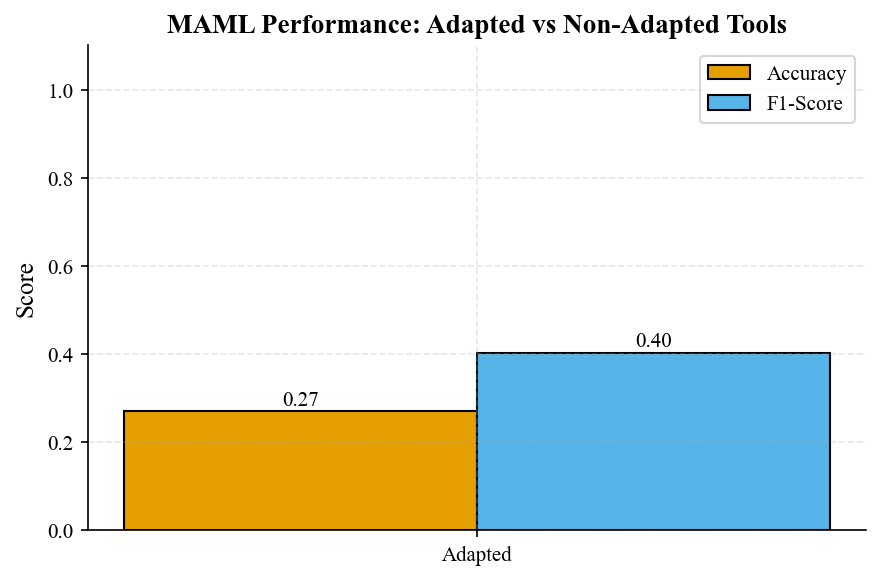

In [15]:
# Visualize adaptation comparison
if maml_loaded and len(eval_df) > 0:
    comparison_data = []
    
    if len(adapted_df) > 0 and acc_adapted is not None:
        comparison_data.append({'Type': 'Adapted', 'Accuracy': acc_adapted, 'F1-Score': f1_adapted})
    
    if len(non_adapted_df) > 0 and acc_non is not None:
        comparison_data.append({'Type': 'Non-Adapted', 'Accuracy': acc_non, 'F1-Score': f1_non})
    
    if comparison_data:
        comp_df = pd.DataFrame(comparison_data)
        
        fig, ax = plt.subplots(figsize=(6, 4))
        
        x = np.arange(len(comp_df))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, comp_df['Accuracy'], width, label='Accuracy',
                       color=COLORS['adapted'], edgecolor='black')
        bars2 = ax.bar(x + width/2, comp_df['F1-Score'], width, label='F1-Score',
                       color=COLORS['meta'], edgecolor='black')
        
        ax.set_ylabel('Score')
        ax.set_title('MAML Performance: Adapted vs Non-Adapted Tools')
        ax.set_xticks(x)
        ax.set_xticklabels(comp_df['Type'])
        ax.legend()
        ax.set_ylim(0, 1.1)
        
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                            xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'adaptation_comparison.png'), dpi=600)
        plt.show()

### 6.2 Confidence Distribution Analysis

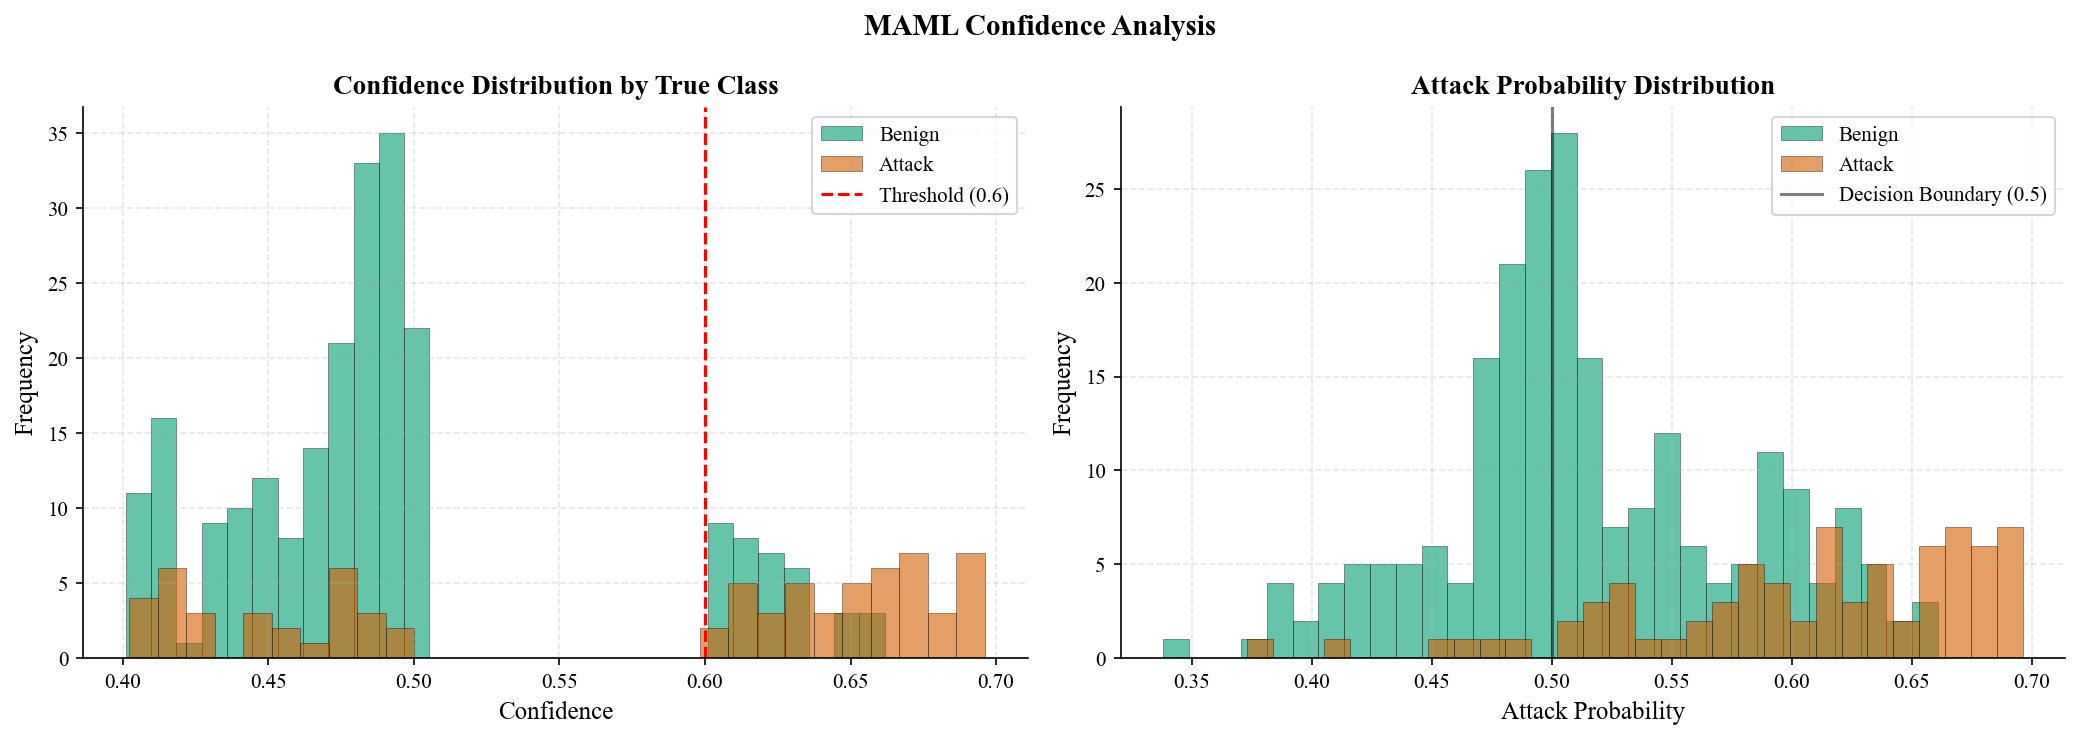

In [16]:
if maml_loaded and len(eval_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confidence by true label
    ax1 = axes[0]
    for label, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
        data = eval_df[eval_df['true_label'] == label]['confidence']
        ax1.hist(data, bins=30, alpha=0.6, label=label.capitalize(),
                color=color, edgecolor='black', linewidth=0.3)
    ax1.axvline(x=maml_detector.config.confidence_threshold, color='red', linestyle='--',
               label=f'Threshold ({maml_detector.config.confidence_threshold})')
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Confidence Distribution by True Class')
    ax1.legend()
    
    # Attack probability distribution
    ax2 = axes[1]
    for label, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
        data = eval_df[eval_df['true_label'] == label]['attack_prob']
        ax2.hist(data, bins=30, alpha=0.6, label=label.capitalize(),
                color=color, edgecolor='black', linewidth=0.3)
    ax2.axvline(x=0.5, color='black', linestyle='-', alpha=0.5, label='Decision Boundary (0.5)')
    ax2.set_xlabel('Attack Probability')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Attack Probability Distribution')
    ax2.legend()
    
    plt.suptitle('MAML Confidence Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'confidence_distribution.png'), dpi=600)
    plt.show()

## 7. Per-Tool Analysis

In [17]:
if maml_loaded and len(eval_df) > 0:
    # Per-tool performance
    tool_metrics = []
    
    for tool_name in eval_df['tool_name'].unique():
        tool_df = eval_df[eval_df['tool_name'] == tool_name]
        tool_valid = tool_df[tool_df['pred_label'] != 'abstain']
        
        if len(tool_valid) == 0:
            continue
        
        y_true_tool = (tool_valid['true_label'] == 'attack').astype(int)
        y_pred_tool = (tool_valid['pred_label'] == 'attack').astype(int)
        
        adapted = tool_valid['adapted'].iloc[0] if len(tool_valid) > 0 else False
        
        tool_metrics.append({
            'tool': tool_name,
            'samples': len(tool_df),
            'coverage': len(tool_valid) / len(tool_df),
            'accuracy': accuracy_score(y_true_tool, y_pred_tool),
            'f1_score': f1_score(y_true_tool, y_pred_tool, zero_division=0),
            'adapted': adapted
        })
    
    tool_metrics_df = pd.DataFrame(tool_metrics).sort_values('f1_score', ascending=False)
    
    print("Per-Tool Performance:")
    print(tool_metrics_df.to_string(index=False))

Per-Tool Performance:
            tool  samples  coverage  accuracy  f1_score  adapted
    s3_operation       32       1.0   0.43750  0.470588     True
deserialize_data       32       1.0   0.28125  0.410256     True
   graphql_query       40       1.0   0.25000  0.400000     True
      ldap_query       36       1.0   0.25000  0.400000     True
       parse_xml       32       1.0   0.25000  0.400000     True
      verify_jwt       28       1.0   0.25000  0.400000     True
   redis_command       40       1.0   0.25000  0.400000     True
 render_template       32       1.0   0.25000  0.400000     True
    send_webhook       32       1.0   0.21875  0.358974     True


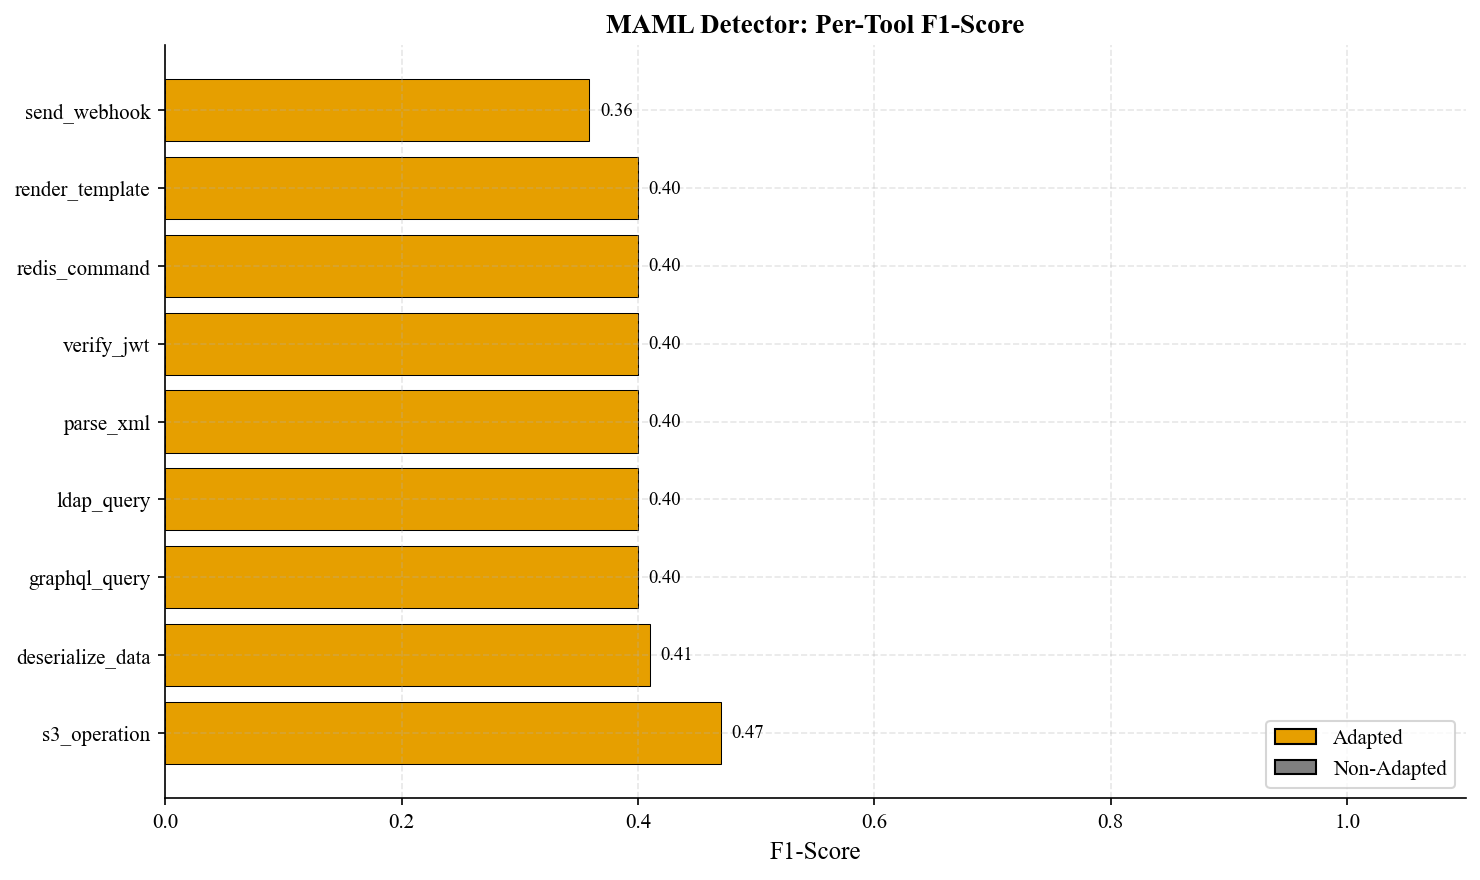

In [18]:
# Visualize per-tool F1 scores
if maml_loaded and len(eval_df) > 0 and len(tool_metrics_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = [COLORS['adapted'] if a else COLORS['neutral'] for a in tool_metrics_df['adapted']]
    
    bars = ax.barh(range(len(tool_metrics_df)), tool_metrics_df['f1_score'],
                   color=colors, edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(tool_metrics_df)))
    ax.set_yticklabels(tool_metrics_df['tool'])
    ax.set_xlabel('F1-Score')
    ax.set_title('MAML Detector: Per-Tool F1-Score')
    ax.set_xlim(0, 1.1)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS['adapted'], edgecolor='black', label='Adapted'),
        Patch(facecolor=COLORS['neutral'], edgecolor='black', label='Non-Adapted')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    for bar, val in zip(bars, tool_metrics_df['f1_score']):
        ax.annotate(f'{val:.2f}', xy=(val, bar.get_y() + bar.get_height()/2),
                    xytext=(5, 0), textcoords='offset points', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'per_tool_f1.png'), dpi=600)
    plt.show()

## 8. Summary and Export

In [19]:
if maml_loaded and len(eval_df) > 0:
    # Compile summary
    summary = {
        'detector': 'maml',
        'classification_type': 'binary',
        'method': 'model_agnostic_meta_learning',
        'encoder': 'distilbert-base-uncased',
        'config': {
            'meta_lr': maml_detector.config.meta_lr,
            'inner_lr': maml_detector.config.inner_lr,
            'adaptation_steps': maml_detector.config.adaptation_steps,
            'first_order': maml_detector.config.first_order,
            'shots': maml_detector.config.shots,
            'hidden_dim': maml_detector.config.hidden_dim,
            'confidence_threshold': maml_detector.config.confidence_threshold
        },
        'adapted_tools': list(maml_detector.adapted_models.keys()),
        'test_samples': len(eval_df),
        'metrics': {
            'coverage': float(coverage) if 'coverage' in dir() else None,
            'accuracy': float(accuracy) if 'accuracy' in dir() and len(valid_df) > 0 else None,
            'precision': float(precision_val) if 'precision_val' in dir() and len(valid_df) > 0 else None,
            'recall': float(recall_val) if 'recall_val' in dir() and len(valid_df) > 0 else None,
            'f1_score': float(f1_val) if 'f1_val' in dir() and len(valid_df) > 0 else None,
            'roc_auc': float(roc_auc) if 'roc_auc' in dir() and len(valid_df) > 0 else None,
            'average_precision': float(ap_score) if 'ap_score' in dir() and len(valid_df) > 0 else None
        },
        'training_history': {
            'epochs': len(maml_detector.training_history.get('meta_loss', [])),
            'final_loss': maml_detector.training_history.get('meta_loss', [None])[-1],
            'final_accuracy': maml_detector.training_history.get('meta_accuracy', [None])[-1]
        },
        'per_tool_metrics': tool_metrics if 'tool_metrics' in dir() else []
    }
    
    # Export
    eval_df.to_csv(os.path.join(RESULTS_DIR, 'maml_predictions.csv'), index=False)
    if 'tool_metrics_df' in dir() and len(tool_metrics_df) > 0:
        tool_metrics_df.to_csv(os.path.join(RESULTS_DIR, 'maml_per_tool.csv'), index=False)
    
    with open(os.path.join(RESULTS_DIR, 'maml_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    print("Results exported successfully.")
else:
    print("MAML detector not loaded or no evaluation data. Skipping export.")

Results exported successfully.


In [20]:
# Final summary
if maml_loaded and len(eval_df) > 0:
    print("\n" + "="*70)
    print("MAML DETECTOR EVALUATION SUMMARY")
    print("="*70)
    print(f"\nMethod: Model-Agnostic Meta-Learning (MAML)")
    print(f"Adaptation steps: {maml_detector.config.adaptation_steps}")
    print(f"Shots per class: {maml_detector.config.shots}")
    print(f"Adapted tools: {len(maml_detector.adapted_models)}")
    print(f"\nBinary Classification Performance:")
    if 'coverage' in dir() and len(valid_df) > 0:
        print(f"  Coverage:  {coverage:.4f}")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision_val:.4f}")
        print(f"  Recall:    {recall_val:.4f}")
        print(f"  F1-Score:  {f1_val:.4f}")
        if 'roc_auc' in dir():
            print(f"  ROC-AUC:   {roc_auc:.4f}")
        if 'ap_score' in dir():
            print(f"  AP:        {ap_score:.4f}")
    print("="*70)
else:
    print("MAML detector not available for evaluation.")


MAML DETECTOR EVALUATION SUMMARY

Method: Model-Agnostic Meta-Learning (MAML)
Adaptation steps: 5
Shots per class: 5
Adapted tools: 32

Binary Classification Performance:
  Coverage:  1.0000
  Accuracy:  0.2697
  Precision: 0.2534
  Recall:    0.9868
  F1-Score:  0.4032
  ROC-AUC:   0.8289
  AP:        0.7168


## Conclusions

### Key Findings

1. **Meta-Learning Effectiveness**: MAML learns a good initialization that enables rapid adaptation to new tools with minimal examples.

2. **Few-Shot Capability**: The detector can adapt to new tools with as few as 5 examples per class, making it practical for deployment scenarios with limited training data.

3. **Adaptation Benefit**: Tools with task-specific adapted models generally show improved performance compared to using the meta-model directly.

4. **Confidence Calibration**: The temperature-scaled softmax provides calibrated probability outputs suitable for ensemble integration.

### Role in Ensemble

The MAML Detector:
- Provides few-shot adaptation capability for new tools
- Carries lowest ensemble weight (0.10) as an optional component
- Enables rapid deployment to new tool types without extensive retraining
- Complements other detectors with meta-learned generalization

### Limitations

- Requires computationally expensive meta-training
- Performance depends on quality of meta-training tasks
- May underperform specialized detectors on well-established tools
- Higher inference cost than rule-based or statistical methods

### References

- Finn, C., Abbeel, P., & Levine, S. (2017). *Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks*. ICML.
- Nichol, A., Achiam, J., & Schulman, J. (2018). *On First-Order Meta-Learning Algorithms*. arXiv.

---

*Evaluation completed. Results saved for thesis documentation.*